## we inherit the model from EXP7, but we specially train it for dense assortment input

In [7]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

start_time = time.time()

N_prod = 250        # number of products
Vec_Len = N_prod + 1
Neck_Len = 30       # bottle neck width
EPOCHS = 10000
SAMPLE_AMOUNT = 5000
BATCH_SIZE = 500
TRAIN_VALI_RATE = 0.9
ADAM_LR = 0.0005

# generate latent parameters
transP = np.load("EXP7_dump/markov_matrix.npy")
lams = np.load("EXP7_dump/arriving_lambda.npy")

model = torch.load("EXP7_dump/bottleneck_model_Large.pth")

# generate synthetic data
INPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
for i in range(SAMPLE_AMOUNT):
    idx = np.random.uniform(low = 0,high = 1)
    if idx > 0.9:
        assort = assort = AG.GenAssortment_Even(N_prod,N_prod)
    else:
        assort = AG.GenAssortment_Even(N_prod,N_prod-1)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)

print("data generated!")
print("total time elapse : ",time.time()-start_time)

train_dataset = TensorDataset(torch.Tensor(INPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]),torch.Tensor(OUTPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]))    
vali_dataset = TensorDataset(torch.Tensor(INPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]),torch.Tensor(OUTPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]))    

train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE)
vali_loader = DataLoader(vali_dataset, shuffle=True, batch_size = len(vali_dataset))

optimizer = optim.Adam(model.parameters(), lr = ADAM_LR)
criterion = nn.BCELoss()

training_losses = np.array([])
vali_losses = np.array([])

for epo in range(1,EPOCHS+1):
    if epo % 50 == 0:
        print("epoch : ",epo)
        print(time.time()-start_time)
    
    for step, (IN, TEST) in enumerate(train_loader):
        
        OUT = model(IN)
        loss = criterion(OUT,TEST)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_pure = loss.detach().item()
        loss_base = criterion(TEST,TEST).detach().item()
        training_losses= np.append(training_losses,(loss_pure - loss_base)/loss_base)
        
    for step, (VALI_IN, VALI_TEST) in enumerate(vali_loader):
        VALI_OUT = model(VALI_IN)
        
        RELATIVE_LOSS = nn.functional.l1_loss(VALI_TEST, VALI_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(VALI_TEST, min = 1/Vec_Len)

        losses = np.mean(torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=4).detach().numpy())
        
        vali_losses = np.append(vali_losses,losses)

np.save('EXP8_dump/bottleneck_train_loss_Dense', training_losses)
np.save('EXP8_dump/bottleneck_vali_loss_Dense', vali_losses)
torch.save(model, "EXP8_dump/bottleneck_model_Dense.pth")

data generated!
total time elapse :  1.1221091747283936


D:\SOFTWARE\ANACONDA\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


epoch :  50
5.324115037918091
epoch :  100
9.589142322540283
epoch :  150
13.844017744064331
epoch :  200
18.03883457183838
epoch :  250
22.27280306816101
epoch :  300
26.458640336990356
epoch :  350
30.781673908233643
epoch :  400
35.135310649871826
epoch :  450
39.48820447921753
epoch :  500
43.96021842956543
epoch :  550
48.19125318527222
epoch :  600
52.50506520271301
epoch :  650
56.84001564979553
epoch :  700
61.17838764190674
epoch :  750
65.74443340301514
epoch :  800
70.17325735092163
epoch :  850
74.62056684494019
epoch :  900
78.9471526145935
epoch :  950
83.23192548751831
epoch :  1000
87.42637181282043
epoch :  1050
91.69690036773682
epoch :  1100
95.78097772598267
epoch :  1150
99.99190998077393
epoch :  1200
104.17999243736267
epoch :  1250
108.3651909828186
epoch :  1300
112.63949227333069
epoch :  1350
116.7906186580658
epoch :  1400
120.94849872589111
epoch :  1450
125.19828176498413
epoch :  1500
129.43434953689575
epoch :  1550
133.70194387435913
epoch :  1600
137.8

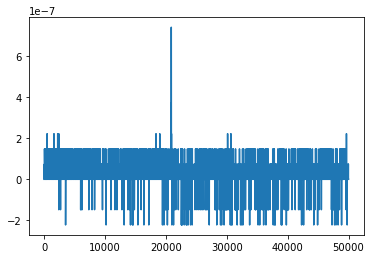

In [10]:
train_loss = np.load('EXP8_dump/bottleneck_train_loss_Dense.npy')
plt.plot(train_loss[40000:])

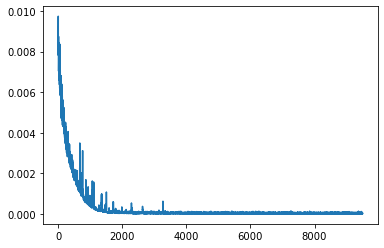

In [11]:
train_loss = np.load('EXP8_dump/bottleneck_vali_loss_Dense.npy')
plt.plot(train_loss[500:])

## test sparse

D:\SOFTWARE\ANACONDA\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


(array([4.68202e+05, 2.40000e+01, 1.61500e+03, 1.48760e+04, 1.72750e+04,
        1.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 5.00000e+00]),
 array([3.2941976e-08, 2.0000003e-01, 4.0000004e-01, 6.0000002e-01,
        8.0000001e-01, 1.0000000e+00, 1.2000000e+00, 1.4000000e+00,
        1.6000000e+00, 1.8000000e+00, 2.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

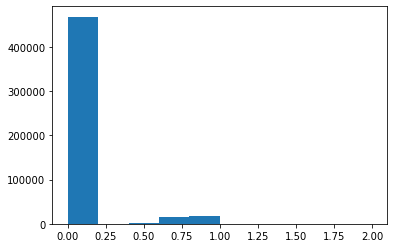

In [12]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

N_prod = 250        # number of products
Vec_Len = N_prod + 1

DENSE_AMOUNT = 2000

model = torch.load("EXP8_dump/bottleneck_model_Dense.pth")
INPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
for i in range(DENSE_AMOUNT):
    assort = AG.GenAssortment_Sparse(N_prod)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)


INPUT=torch.Tensor(INPUT)
OUTPUT = torch.Tensor(OUTPUT)

MODEL_OUT = model(INPUT)

RELATIVE_LOSS = nn.functional.l1_loss(OUTPUT, MODEL_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(OUTPUT, min = 1/Vec_Len)

losses = torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=2).detach().numpy()

plt.hist(losses)

## test 3/4 dense

(array([3.42855e+05, 1.23060e+05, 2.90390e+04, 4.57400e+03, 2.27900e+03,
        1.90000e+01, 1.90000e+01, 2.60000e+01, 1.00000e+01, 1.19000e+02]),
 array([5.5836002e-09, 2.0000000e-01, 4.0000001e-01, 6.0000002e-01,
        8.0000001e-01, 1.0000000e+00, 1.2000000e+00, 1.4000000e+00,
        1.6000000e+00, 1.8000000e+00, 2.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

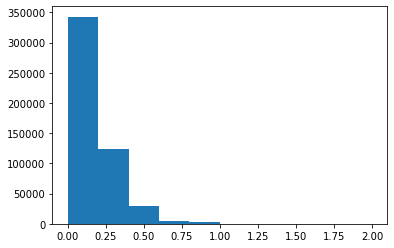

In [13]:
N_prod = 250        # number of products
Vec_Len = N_prod + 1

DENSE_AMOUNT = 2000

model = torch.load("EXP8_dump/bottleneck_model_Dense.pth")
INPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
for i in range(DENSE_AMOUNT):
    assort = AG.GenAssortment_Even(N_prod, 3/4)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)


INPUT=torch.Tensor(INPUT)
OUTPUT = torch.Tensor(OUTPUT)

MODEL_OUT = model(INPUT)

RELATIVE_LOSS = nn.functional.l1_loss(OUTPUT, MODEL_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(OUTPUT, min = 1/Vec_Len)

losses = torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=2).detach().numpy()

plt.hist(losses)

## dense

(array([4.98376e+05, 2.49500e+03, 3.67000e+02, 1.90000e+02, 1.01000e+02,
        4.80000e+01, 2.00000e+01, 5.30000e+01, 6.40000e+01, 2.86000e+02]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

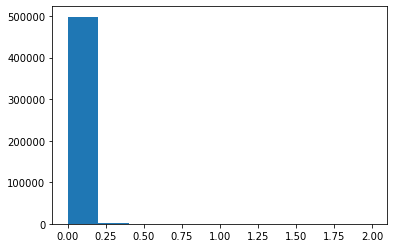

In [14]:
DENSE_AMOUNT = 2000


INPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
for i in range(DENSE_AMOUNT):
    assort = AG.GenAssortment_Fixed(N_prod, fixed_num = N_prod-1)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)


INPUT=torch.Tensor(INPUT)
OUTPUT = torch.Tensor(OUTPUT)

MODEL_OUT = model(INPUT)

RELATIVE_LOSS = nn.functional.l1_loss(OUTPUT, MODEL_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(OUTPUT, min = 1/Vec_Len)

losses = torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=2).detach().numpy()

plt.hist(losses)

## Even generation: tune with different lambda

(array([4.49845e+05, 1.10000e+02, 5.57800e+03, 2.36880e+04, 2.27710e+04,
        2.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00, 3.00000e+00]),
 array([2.4491746e-08, 2.0000002e-01, 4.0000001e-01, 6.0000002e-01,
        8.0000001e-01, 1.0000000e+00, 1.2000000e+00, 1.4000000e+00,
        1.6000000e+00, 1.8000000e+00, 2.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

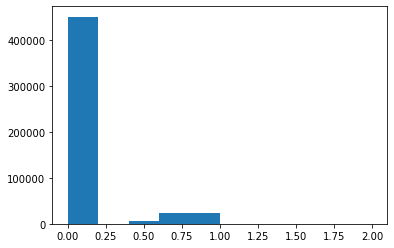

In [24]:
N_prod = 250        # number of products
Vec_Len = N_prod + 1

DENSE_AMOUNT = 2000

model = torch.load("EXP8_dump/bottleneck_model_Dense.pth")
INPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
for i in range(DENSE_AMOUNT):
    assort = AG.GenAssortment_Even(N_prod, 0.1)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)


INPUT=torch.Tensor(INPUT)
OUTPUT = torch.Tensor(OUTPUT)

MODEL_OUT = model(INPUT)

RELATIVE_LOSS = nn.functional.l1_loss(OUTPUT, MODEL_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(OUTPUT, min = 1/Vec_Len)

losses = torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=2).detach().numpy()

plt.hist(losses)